In [1]:
import os, torch, pandas as pd, utils.model.DHRNet as models,numpy as np 
from torch.utils.data import TensorDataset, DataLoader
from utils.preprocessREVI import preprocessor
pre = preprocessor()
M_lst = [None, 'M1', 'M2']
tr_evlst = [None, 'pcap_ISCX', 'pcap_REVI']

#模型選擇、資料集選擇
msel, dsel = 2,0
df0, dt0, columns = pre.data_preprocess(f'./datasets/Wednesday-WorkingHours.{tr_evlst[msel]}.csv', mn=M_lst[msel])
df0 = pre.data_reshape(reshape_data=df0, reshape_cnn='1d')

BENIGN  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  DoS slowloris  Heartbleed
1       0              0         0                 0              0             319186
0       0              1         0                 0              0             159049
        1              0         0                 0              0               7647
        0              0         0                 1              0               5707
                                 1                 0              0               5109
                                 0                 0              1                 11
dtype: int64


In [2]:
from utils.losses.SLCPLoss import SLCPLoss
latent=3
batch_size = 256
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sd = 0
model_pth = f'./save_models/{M_lst[msel]}_sd_{sd}.pth'
# model_pth = f'./save_models/checkpoints/cnn_{M_lst[msel]}_sl_1.0_sd_{sd}.pth'
net = models.DHRNet(dt0.columns.__len__(), latent=latent)
cp_metas = torch.load(model_pth,map_location="cpu")
slcp_l = SLCPLoss(dt0.columns.__len__(), latent)
slcp_l.points = torch.nn.Parameter(torch.from_numpy(cp_metas['centers']).float())
slcp_l = slcp_l.cuda()
net.load_state_dict(cp_metas.get('model_state_dict'))
net.cuda()
cp_metas.keys()
centers = cp_metas['centers']
print((cp_metas.get('train_acc') + cp_metas.get('val_acc')) / 2)

99.92525809698643


In [3]:
# 驗證函數
def get_features(net, testloader, s_loss):
    net.eval()
    reconst_criterion = torch.nn.MSELoss(reduction='none')
    opt_lst, gt_lst, tg_lst, loss_lst, prd_lst = np.empty((0,3)), np.empty((0)), np.empty((0)), np.empty((0)), np.empty((0))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            raw_gts, targets = torch.max(labels.data, 1)
            _, cf, _r, _e = net(inputs)
            logits, sloss = s_loss(cf, 0, labels=targets)
            bcel = reconst_criterion(_r, inputs)
            bcel = torch.sum(bcel.detach(), 2)
            _, predicted = torch.max(logits.data, 1)
            opt_lst = np.vstack((opt_lst, cf.detach().cpu().numpy()))
            gt_lst = np.hstack((gt_lst, raw_gts.detach().cpu().numpy()))
            tg_lst = np.hstack((tg_lst, targets.detach().cpu().numpy()))
            loss_lst = np.hstack((loss_lst, bcel.detach().cpu().numpy().flatten()))
            prd_lst = np.hstack((prd_lst, predicted.detach().cpu().numpy()))
    dfopt = pd.DataFrame(np.hstack((opt_lst, prd_lst.reshape(-1,1), gt_lst.reshape(-1,1), tg_lst.reshape(-1,1), loss_lst.reshape(-1,1))), columns=['o_x', 'o_y', 'o_z', 'predict', 'raw_gt', 'groundtruth', 'reconst'] )
    return dfopt

In [4]:
tensor_x = torch.Tensor(df0) # transform to torch tensor
tensor_y = torch.Tensor(dt0.to_numpy())

wed_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
test_dataloader = DataLoader(wed_dataset, batch_size=batch_size) # create your dataloader

99.93336138463366
(0.9993419856261537, 0.9993336138463366, 0.9993355826635254, None)


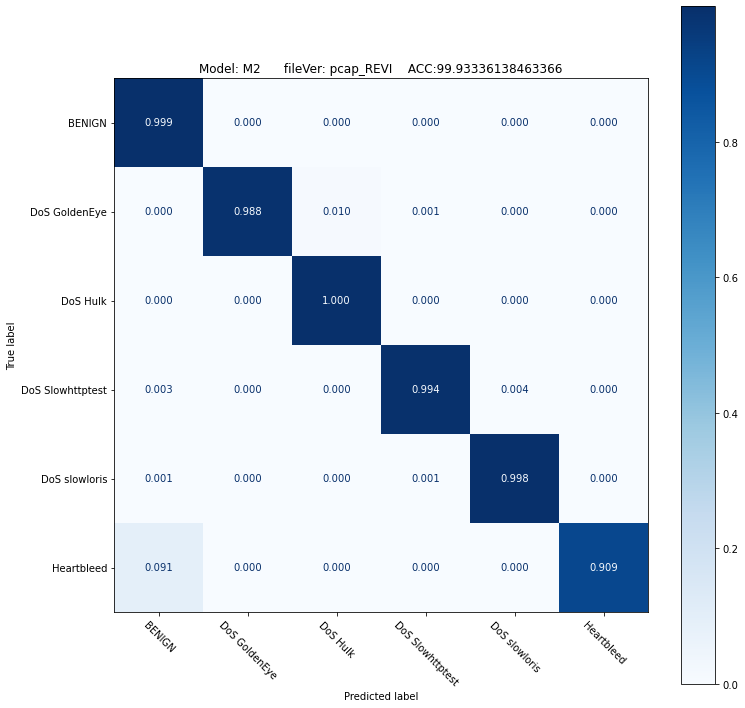

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
eval_org = get_features(net, test_dataloader, slcp_l)
print(100 * eval_org[eval_org.predict == eval_org.groundtruth].shape[0] / eval_org.shape[0])
# eval_org.predict[eval_org.predict > 0] = 1
# eval_org.groundtruth[(eval_org.groundtruth > 0) | (eval_org.raw_gt < 1)] = 1
# print(precision_recall_fscore_support(y_true=eval_org.groundtruth, y_pred=eval_org.predict, average='binary'))
print(precision_recall_fscore_support(y_true=eval_org.groundtruth, y_pred=eval_org.predict, average='weighted'))
fig, ax = plt.subplots(figsize=(10,10))
plt.tight_layout()
ConfusionMatrixDisplay.from_predictions(y_true=eval_org.groundtruth, y_pred=eval_org.predict, cmap='Blues', values_format='.3f', ax=ax, normalize='true' ,display_labels=dt0.columns.to_list(), xticks_rotation=-45)
ax.set_title(f'Model: {M_lst[msel]}      fileVer: {tr_evlst[msel]}    ACC:{100 * eval_org[eval_org.predict == eval_org.groundtruth].shape[0] / eval_org.shape[0]}')
# plt.savefig(f'./SSE/{M_lst[msel]}_fxsd/origin_{sd}.png', transparent=False, facecolor='white')
plt.show()

In [6]:
# from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
# print(100 * eval_org[eval_org.predict == eval_org.groundtruth].shape[0] / eval_org.shape[0])
# eval_org.predict[eval_org.predict > 0] = 1
# eval_org.groundtruth[(eval_org.groundtruth > 0) | (eval_org.raw_gt < 1)] = 1
# print(precision_recall_fscore_support(y_true=eval_org.groundtruth, y_pred=eval_org.predict, average='binary'))
# # print(precision_recall_fscore_support(y_true=eval_org.groundtruth, y_pred=eval_org.predict, average='weighted'))
# fig, ax = plt.subplots(figsize=(10,10))
# plt.tight_layout()
# # ConfusionMatrixDisplay.from_predictions(y_true=eval_org.groundtruth, y_pred=eval_org.predict, cmap='Blues', values_format='.3f', ax=ax, normalize='true' ,display_labels=dt0.columns.to_list(), xticks_rotation=-45)
# ConfusionMatrixDisplay.from_predictions(y_true=eval_org.groundtruth, y_pred=eval_org.predict, cmap='Blues', values_format='.3f', ax=ax, normalize='true' ,display_labels=['BENIGN', 'MALICIOUS'], xticks_rotation=-45)
# ax.set_title(f'Model: {M_lst[msel]}      fileVer: {tr_evlst[msel]}    ACC:{100 * eval_org[eval_org.predict == eval_org.groundtruth].shape[0] / eval_org.shape[0]}')
# # plt.savefig(f'./SSE/{M_lst[msel]}_fxsd/origin_{sd}.png', transparent=False, facecolor='white')
# plt.show()

In [15]:
# df2, dt2, columns = pre.data_preprocess('./datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', filter_l=['BENIGN'], mn='M1', ac=False, wbo=False)
# df2, dt2, columns = pre.data_preprocess('./datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', filter_l=['DDoS'], mn='M1', ac=False, wbo=False)
# df2, dt2, columns = pre.data_preprocess('./datasets/Friday-WorkingHours-Afternoon-DDoS.pcap_REVI.csv', filter_l=['BENIGN'], mn='M2', ac=False, wbo=False)
# df2, dt2, columns = pre.data_preprocess('./datasets/Friday-WorkingHours-Afternoon-DDoS.pcap_REVI.csv', mn='M2', ac=False, wbo=False, filter_l=['DDoS'])
# df2, dt2, columns = pre.data_preprocess_Bin('./datasets/Friday-WorkingHours-Afternoon-DDoS.pcap_REVI.csv', filter_l=['BENIGN'], mn='M2', ac=False, wbo=False)
# df2, dt2, columns = pre.data_preprocess_Bin('./datasets/Friday-WorkingHours-Afternoon-DDoS.pcap_REVI.csv', filter_l=['MALICIOUS'], mn='M2', ac=False, wbo=False)

# df2, dt2, columns = pre.data_preprocess('./datasets/DDoS_TCP.csv', mn='M2', ac=False, wbo=False)

d_lst = [None, 'DDoS', 'DrDoS_LDAP','DrDoS_MSSQL','DrDoS_DNS','DrDoS_NetBIOS','DrDoS_NTP','DrDoS_UDP','DrDoS_SNMP','DrDoS_SSDP','syn_data']
dsel = 10
print(M_lst[msel], d_lst[dsel])
df2, dt2, columns = pre.data_preprocess(f'./datasets/{d_lst[dsel]}.csv', mn='M2019', ac=False, filter_l=['Syn'])
# df2, dt2, columns = pre.data_preprocess(f'./datasets/{d_lst[dsel]}.csv', mn='M2019', ac=False, filter_l=[d_lst[dsel]])
df2 = pre.data_reshape(reshape_data=df2, reshape_cnn='1d')

M2 syn_data
BENIGN  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  DoS slowloris  Heartbleed
0       0              0         0                 0              0             1380015
dtype: int64


In [16]:
tensor_x = torch.Tensor(df2) # transform to torch tensor
tensor_y = torch.Tensor(dt2.to_numpy())

fri_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
test2_dataloader = DataLoader(fri_dataset, batch_size=batch_size) # create your dataloader

eval_uknown = get_features(net, test2_dataloader, slcp_l)
eval_uknown['c_flag'] = 'r'

In [17]:
# from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score, confusion_matrix
# import matplotlib.pyplot as plt
# from contextlib import redirect_stdout
# # eval_uknown = get_features(net, test_dataloader, slcp_l)
# eval_uknown.predict[eval_uknown.predict > 0] = 1
# eval_uknown.groundtruth[(eval_uknown.groundtruth > 0) | (eval_uknown.raw_gt < 1)] = 1
# with open(f'./logs/{M_lst[msel]}_fxsd.log','a') as fd:
#     with redirect_stdout(fd):
#         tn, fp, fn, tp = confusion_matrix(y_true=eval_uknown.groundtruth, y_pred=eval_uknown.predict).ravel()
#         s_acc = accuracy_score(y_true=eval_uknown.groundtruth, y_pred=eval_uknown.predict)
#         s_precision, s_recall, s_fscore, _ = precision_recall_fscore_support(y_true=eval_uknown.groundtruth, y_pred=eval_uknown.predict, average='binary')
#         print(f'{d_lst[dsel]},{tn},{fp},{fn},{tp},{s_acc},{s_precision},{s_recall},{s_fscore}')
# fig, ax = plt.subplots(figsize=(10,10))
# ConfusionMatrixDisplay.from_predictions(y_true=eval_uknown.groundtruth, y_pred=eval_uknown.predict, values_format='.3f', ax=ax, normalize='true' ,display_labels=['BENIGN', 'MALICIOUS'], xticks_rotation=-45)
# ax.set_title(f'Model: {M_lst[msel]}      fileVer: {tr_evlst[msel]}    ACC:{eval_uknown[eval_uknown.predict == eval_uknown.groundtruth].shape[0] / eval_uknown.shape[0]}')#B_other:{"Yes" if msel == 3 else "No"}')
# # plt.savefig(f'./SSE/{M_lst[msel]}_fxsd/origin_bin.png', transparent=False, facecolor='white')
# # plt.savefig(f'./SSE/M2_{d_lst[dsel]}.png', transparent=False, facecolor='white')
# plt.show()
# # plt.close()

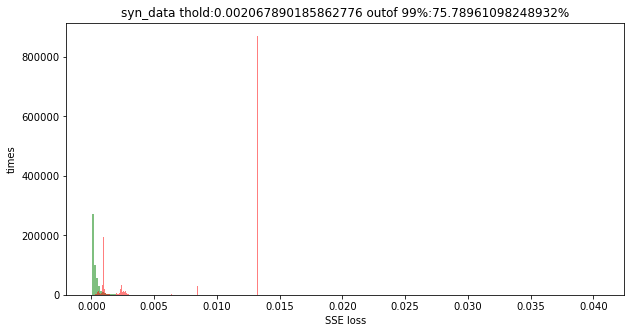

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
thold = np.percentile(eval_org.reconst,[99])[0]
ax.set_title(f'{d_lst[dsel]} thold:{thold} outof 99%:{eval_uknown[eval_uknown.reconst > np.percentile(eval_org.reconst,[99])[0]].shape[0] * 100 / eval_uknown.shape[0]}%')
ax.set_ylabel('times')
ax.set_xlabel('SSE loss')
ax.hist(eval_org.reconst, 250, facecolor='g', alpha=0.5)
ax.hist(eval_uknown.reconst , 250, facecolor='r', alpha=0.5)
# plt.savefig(f'./SSE/{M_lst[msel]}_sd/{d_lst[dsel]}_{sd}.png', transparent=False, facecolor='white')
plt.show()

In [28]:
from sklearn import linear_model
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
def create_sgd_ocsvm(nu=0.5, n_comp=100, tol=1e-7, gamma=0.1):
    clf = make_pipeline(
        Nystroem(gamma=gamma, random_state=222, n_components=n_comp),
        linear_model.SGDOneClassSVM(
            nu=nu,
            shuffle=True,
            fit_intercept=True,
            random_state=222,
            tol=tol,
        )
    )
    return clf

0.6369390487670898
L_Lim:1.9676128175536427, H_lim:1.9955279313655416
BENIGN 225197 24091 201106 89.30225535864155
預測為 BENIGN 類 共：1271003 SSE後：225197


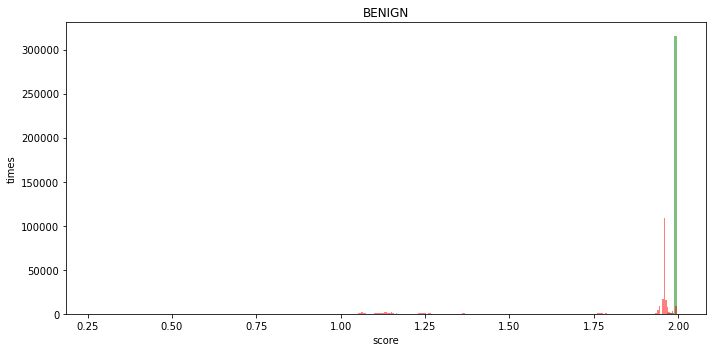

L_Lim:1.5832838549698678, H_lim:1.9470704792832652
DoS GoldenEye 3 0 3 100.0
預測為 DoS GoldenEye 類 共：3 SSE後：3


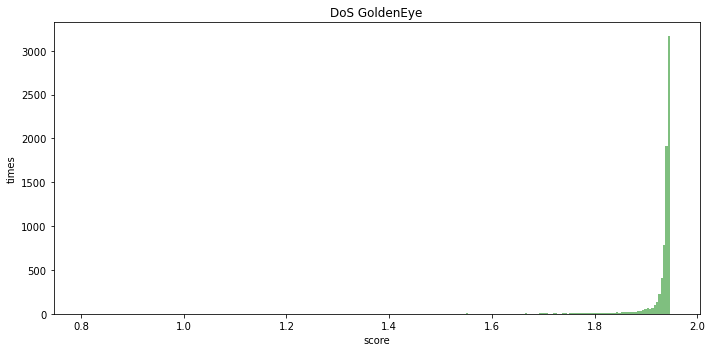

L_Lim:1.9835039095713596, H_lim:1.9944614909675535
DoS Hulk 38616 0 38616 100.0
預測為 DoS Hulk 類 共：38637 SSE後：38616


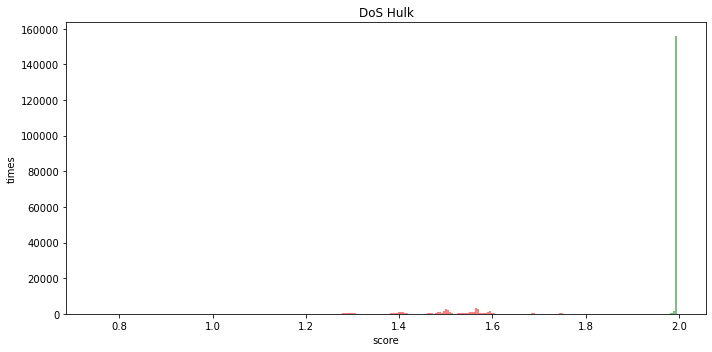

L_Lim:1.5594266253583586, H_lim:1.913310067436747
DoS Slowhttptest 14537 604 13933 95.84508495563045
預測為 DoS Slowhttptest 類 共：14609 SSE後：14537


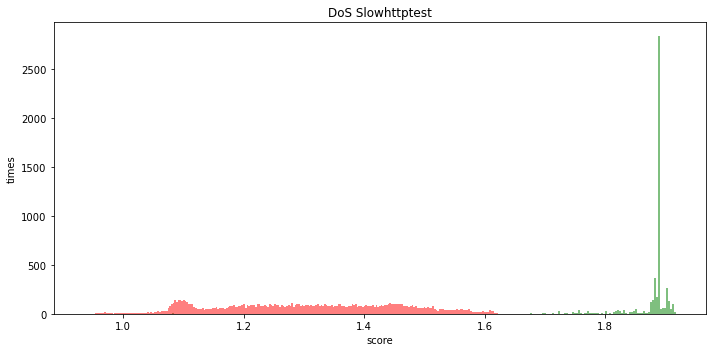

L_Lim:1.6376195260610136, H_lim:1.942464886185826
DoS slowloris 55754 796 54958 98.57229974530975
預測為 DoS slowloris 類 共：55763 SSE後：55754


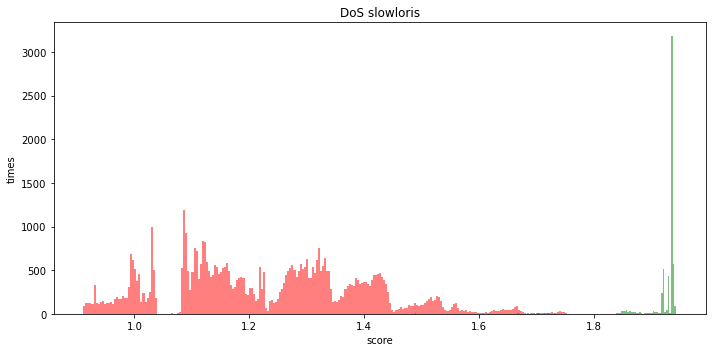

檢測時間:4.607693195343018 未檢出:24091, 檢出(惡意)108910, 檢出(未知)308616, SSE檢出1045908, 總防禦率:0.9825429433738039


In [41]:
import matplotlib.pyplot as plt
import time, numpy as np
svm_models = dict()
start = time.time()
for _ in range(len(pre.sort_lst)):
    fltr = (eval_org.predict == _) & (eval_org.predict == eval_org.groundtruth)
    X = (eval_org.loc[fltr, ['o_x', 'o_y', 'o_z']]).to_numpy()
    clf = create_sgd_ocsvm(nu=0.5, n_comp= 5 if (X.shape[0] < 100) else 10, gamma=0.1)
    clf.fit(X)
    svm_models[pre.sort_lst[_]] = clf
print(time.time() - start)
# TTP, TFN, TFP , TTN = 0,0,0,0
total_outlier, total_dect, total_undect = 0, 0, 0
for _ in range(len(pre.sort_lst)):
    flt_thd = (eval_uknown.reconst <= thold)
    fltr_prd = (eval_uknown.predict == _)
    fltr_exp = (eval_org.predict == _) & (eval_org.predict == eval_org.groundtruth)
    # 被判斷為該類的數量要大於1才能比對
    if (eval_uknown[flt_thd & fltr_prd]).shape[0] < 1:
        continue
    RSVM = svm_models.get(pre.sort_lst[_])
    
    sc_inliers = RSVM.score_samples(eval_org.loc[fltr_exp, ['o_x', 'o_y', 'o_z']].to_numpy())
    # pd_inliers = RSVM.predict(eval_org.loc[fltr_exp, ['o_x', 'o_y', 'o_z']].to_numpy())
    sc_outliers = RSVM.score_samples(eval_uknown.loc[flt_thd & fltr_prd, ['o_x', 'o_y', 'o_z']].to_numpy())
    # pd_outliers = RSVM.predict(eval_uknown.loc[flt_thd & fltr_prd, ['o_x', 'o_y', 'o_z']].to_numpy())
    # print(np.percentile(sc_inliers,[0.15, 1, 5, 10, 15,50,99.7]))
    # print(np.percentile(sc_outliers,[0.15, 1, 5, 10, 15,50,99.7]))
    L_lim, H_lim = np.percentile(sc_inliers,[0.5,99.5])
    outsider_c = sc_outliers[(sc_outliers<L_lim) | (sc_outliers>H_lim)].shape[0]
    outsider_r = 100 * outsider_c / sc_outliers.shape[0]
    print(f'L_Lim:{L_lim}, H_lim:{H_lim}')
    print(pre.sort_lst[_], sc_outliers.shape[0], sc_outliers.shape[0] - outsider_c, outsider_c, outsider_r)
    total_outlier += outsider_c
    if (_ == 0):
        total_undect += (sc_outliers.shape[0] - outsider_c)
    else:
        total_dect += sc_outliers.shape[0]
    # TP, FN, FP, TN = pd_outliers[pd_outliers == -1].size, pd_outliers[pd_outliers == 1].size, pd_inliers[pd_inliers == -1].size, pd_inliers[pd_inliers == 1].size
    # TTP, TFN, TFP, TTN = TTP + TP, TFN + FN, TFP + FP , TTN + TN
    # DR = TP / (FN + TP)
    # FPR = FP / (TN + FP)
    print(f'預測為 {pre.sort_lst[_]} 類 共：{(eval_uknown[fltr_prd]).shape[0]} SSE後：{(eval_uknown[flt_thd & fltr_prd]).shape[0]}')# TP:{TP}, FN:{FN}, FP:{FP}, TN:{TN} DR:{DR}, FPR:{FPR}')
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title(f'{pre.sort_lst[_]}')
    ax.set_ylabel('times')
    ax.set_xlabel('score')
    ax.hist(sc_inliers, 250, facecolor='g', alpha=0.5)
    ax.hist(sc_outliers , 250, facecolor='r', alpha=0.5)
    plt.tight_layout()
    plt.show()
# SSE_DECT= eval_uknown.shape[0] - eval_uknown[flt_thd].shape[0]
# print(f'TTN:{TTN}, TTP:{TTP}, TFN:{TFN}, TFP:{TFP} TDR:{TTP / (TFN + TTP)}, TFPR:{TFP / (TTN + TFP)}')
# print(f'SSE+TDR:{(eval_uknown.shape[0] - TFN) / eval_uknown.shape[0]}')
print(f'檢測時間:{time.time() - start} 未檢出:{total_undect}, 檢出(惡意){total_dect}, 檢出(未知){total_outlier}, SSE檢出{eval_uknown[eval_uknown.reconst > thold].shape[0]}, 總防禦率:{(eval_uknown.shape[0] - total_undect) / eval_uknown.shape[0]}')

scatter!!


/tmp/ipykernel_4141786/800782685.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


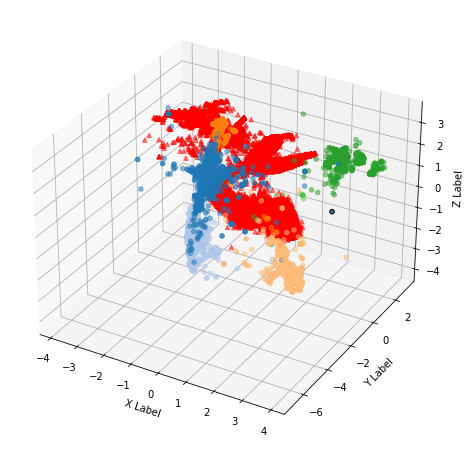

In [21]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
print('scatter!!')
cmp = plt.get_cmap('tab20')(range(pre.sort_lst.__len__()))
ax.scatter(xs=eval_org.o_x, ys=eval_org.o_y, zs=eval_org.o_z, c=cmp[eval_org.groundtruth.astype('int').to_numpy()], marker='o', alpha=0.5)
ax.scatter(xs=eval_uknown.o_x, ys=eval_uknown.o_y, zs=eval_uknown.o_z, c=eval_uknown.c_flag, marker='^', alpha=0.5)
ax.scatter(xs=centers[:,0], ys=centers[:,1], zs=centers[:,2], marker='o', alpha=1.0, linewidths=1,edgecolors='black')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()